In [17]:
import torch as t
import pandas as pd
import numpy as np
import torch.nn as nn 
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchvision import transforms as trf
from torch.utils.data import Dataset , DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import os 

In [18]:
print(t.cuda.is_available())
print(t.__version__)

if t.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
dev='cpu'
device = t.device(dev)  
print(device)
print(t.cuda.get_device_name(0))
print(t.cuda.get_device_properties(0))

True
1.13.0+cu117
cpu
NVIDIA GeForce RTX 2060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6143MB, multi_processor_count=30)


In [19]:
class CrowdDataSet(Dataset):
    def __init__(self, img_dir, label_dir, img_transforms=None, label_transforms=None):
        self.img_dir = os.path.join(img_dir, "images")
        self.label_dir = os.path.join(label_dir, "image_labels.txt")
        self.img_transforms = img_transforms
        self.label_transforms = label_transforms
        self.db = pd.read_csv(self.label_dir)

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        temp = str(self.db.iloc[index, 0])
        img_path = os.path.join(self.img_dir, ('0'*(4-len(temp)))+temp)+".jpg"
        
        image = read_image(img_path)
        #print(img_path,image.shape)
        if image.shape[0]==1:
            image=image[0,:,:].repeat(3,1,1)
        label = t.tensor(self.db.iloc[index, 1],dtype=t.float)
        if self.img_transforms:
            image=self.img_transforms(image)
        if self.label_transforms:
            label=self.label_transforms(label)
            
        return image, label


In [20]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(e,device) for e in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device) -> None:
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [21]:
default_size=(256,256)

def resize(img,size):
    h,w=size
    c_h,c_w=img.shape[1],img.shape[2]
    if h<=-1 and w>-1:
        return trf.Resize(size=(int(w*c_h/c_w),w))(img)
    elif w<=-1 and h>-1:
        return trf.Resize(size=(h,int(h*c_w/c_h)))(img)
    elif w>-1 and h>-1:
        return trf.Resize(size=(h,w))(img)
    else:
        return img



def custom_pad(image,size=default_size):
    h,w=size
    c_h,c_w=image.shape[1],image.shape[2]
    if c_w>w:
        image=resize(image,(-1,w))
    c_h,c_w=image.shape[1],image.shape[2]
    if c_h>h:
        image=resize(image,(h,-1))
        
    c_h,c_w=image.shape[1],image.shape[2]
    if c_h<h:
        image= trf.Pad(padding=(0,np.abs(c_h-h)//2))(image)
    elif c_w<w:
        image= trf.Pad(padding=(np.abs(c_w-w)//2,0))(image)
    image=image=trf.Resize(size=(h,w))(image)/255
    return image

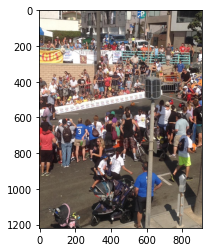

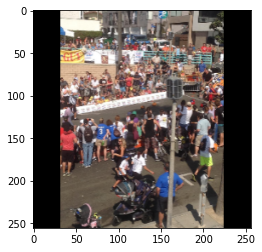

In [22]:
image =read_image('dataset\\test\images\\4145.jpg')
plt.figure(1)
plt.imshow(image.permute(1,2,0))
image_t=custom_pad(image)
plt.figure(2)
plt.imshow(image_t.permute(1,2,0))


In [23]:
bs=32
dirs={x:os.path.join('dataset',x) for x in ['test','train','val']}
#data_set={x:CrowdDataSet(dirs[x],dirs[x],trf.Lambda(custom_pad)) for x in dirs}
data_set={x:CrowdDataSet(dirs[x],dirs[x],trf.Resize(default_size)) for x in dirs}
data_loader_={x:DataLoader(data_set[x],bs,shuffle=False) for x in dirs}
data_loader={x:DeviceDataLoader(data_loader_[x],device) for x in dirs}

In [27]:

N=10*default_size[0]//4*default_size[1]//4
print(N)
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding =1)
        self.conv2 = nn.Conv2d(50, 30, kernel_size=3, padding =1)
        self.conv3 = nn.Conv2d(30, 10, kernel_size=3, padding =1)
        self.fc1 = nn.Linear(N, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, N)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        x = F.relu(self.fc2(x))
        #print(x.shape)
        #print(x[:,0].shape)
        return x[:,0]

40960


In [28]:
model = CNN()
model_name = 'crowd_counting_v2.mdl'
to_device(model, device)
# model=t.load(model_name)

optimizer = t.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = t.optim.Adam(model.parameters(), lr = 0.001)


# on sélectionne les log vraisemblances pour les vraies classes:
#loss_fn =  t.nn.NLLLoss()
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()


In [29]:
import time
time_ = time.time()

train_losses = []
train_accs = []

# boucle d'apprentissage:
for epoch in range(100):
    print('epoch :' + str(epoch))
    
    running_loss_train = 0.
    running_corrects_train = 0.
    
    # entraînement
    for x, label in tqdm(data_loader['train']):
        
        optimizer.zero_grad()
        output = model(x)
        #print(output,output.shape,label,label.shape)

        l = loss_fn(output, label)
        l.backward()     
        optimizer.step()

        #prédictions:

        #print(output.is_cuda,x.is_cuda,label.is_cuda)
        # compteurs
        running_loss_train += l.item() * x.shape[0]
        allowed_var=t.pow(label.data*0.2,2) 
        allowed_var=t.where(allowed_var==0,t.ones(allowed_var.shape)*5,allowed_var)
        #print(allowed_var)
        running_corrects_train += t.mean(t.exp(-t.pow(output - label.data,2)/allowed_var)).cpu()
        if running_corrects_train.isnan():
            print(f"{running_corrects_train} is nan")
            print(allowed_var,output,label.data,output - label.data,t.exp(-t.pow(output - label.data,2)/allowed_var),sep='\n')
        #print(output,label.data,output - label.data,t.exp(-t.pow(output - label.data,2)/allowed_var),sep='\n')

    #print(allowed_var,output,label.data,output - label.data,t.exp(-t.pow(output - label.data,2)/allowed_var),sep='\n')

    # calcul et stockage des scores d'entraînement

    epoch_loss_train = running_loss_train / len(data_loader['train'])
    epoch_acc_train = running_corrects_train.float() / len(data_loader['train'])

    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)
    if len(train_accs)==1 or train_accs[-1]>train_accs[-2]:
        t.save(model,f'./{model_name}')

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    new_t = time.time()
    print('time ' +str(round(new_t- time_)))
    time_ = new_t

print(train_losses,train_accs)

epoch :0


  0%|          | 0/71 [00:01<?, ?it/s]


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
print(allowed_var,output,label.data,output - label.data,t.exp(-t.pow(output - label.data,2)/allowed_var),sep='\n')


tensor([3.1684e+02, 5.8564e+02, 2.3040e+01, 2.9160e+01, 1.1022e+03, 6.8558e+03,
        7.6176e+02, 5.1266e+03, 3.1684e+02, 1.2544e+02, 1.1156e+03, 6.9802e+04,
        5.4760e+01, 4.9000e+01, 5.7600e+02, 4.9284e+02, 1.3456e+02, 1.3250e+03,
        2.7956e+04, 7.8400e+00, 1.6000e+01, 1.8496e+02, 1.1236e+04, 1.9600e+00,
        7.9524e+02, 1.5962e+06, 8.1360e+03, 3.6240e+03, 2.0874e+06, 4.1616e+02,
        9.3636e+02])
tensor([114.9592,  81.7253, 119.4000, 121.6855, 138.9230, 127.7635, 157.7854,
        118.0185,  71.5661,  85.9470, 102.5840, 110.3214, 122.2432,  84.2060,
         75.9773, 127.1149, 100.3983,  87.4991,  87.6533, 131.9203, 138.4360,
         99.3087,  59.7541, 114.0794, 118.9944, 112.2040, 104.3188, 137.9927,
         63.0803, 125.7050,  92.3102], grad_fn=<SelectBackward0>)
tensor([8.9000e+01, 1.2100e+02, 2.4000e+01, 2.7000e+01, 1.6600e+02, 4.1400e+02,
        1.3800e+02, 3.5800e+02, 8.9000e+01, 5.6000e+01, 1.6700e+02, 1.3210e+03,
        3.7000e+01, 3.5000e+01, 1.2000e+0

In [ ]:
t.mean(t.exp(-t.pow(output - label.data,2)/allowed_var))


tensor(0.1021, grad_fn=<MeanBackward0>)

In [ ]:
t.save(model,f'./{model_name}')